In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
import tensorflow

In [ ]:
link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv'
df = pd.read_csv(link)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

we will one hot encode the type column

In [ ]:
newType = pd.get_dummies(df.Type, prefix='ProductID')
print(newType.head())

   ProductID_H  ProductID_L  ProductID_M
0            0            0            1
1            0            1            0
2            0            1            0
3            0            1            0
4            0            1            0


In [ ]:
df = df.drop(['UDI','Type','Product ID','TWF','HDF','PWF','OSF','RNF', 'Machine failure'], axis = 1)


In [ ]:
df_new = pd.read_csv(link)
failure = []

for i in range(df_new.shape[0]):
    if df_new.loc[i,'TWF'] == 1:
        failure.append('TWF')
    elif df_new.loc[i,'HDF'] == 1:
        failure.append('HDF')
    elif df_new.loc[i,'PWF'] == 1:
        failure.append('PWF')
    elif df_new.loc[i,'OSF'] == 1:
        failure.append('OSF')
    elif df_new.loc[i,'RNF'] == 1:
        failure.append('RNF')
    else: 
        failure.append('No Failure')

df_new["Failure"] = failure

In [ ]:
failure = pd.DataFrame(df_new["Failure"])
failure

,Failure
0,No Failure
1,No Failure
2,No Failure
3,No Failure
4,No Failure
...,...
9995,No Failure
9996,No Failure
9997,No Failure
9998,No Failure


In [ ]:
failure.value_counts()

Failure   
No Failure    9652
HDF            115
PWF             91
OSF             78
TWF             46
RNF             18
dtype: int64

In [ ]:
df = pd.concat([df,newType, failure],axis=1)

In [ ]:
df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],ProductID_H,ProductID_L,ProductID_M,Failure
0,298.1,308.6,1551,42.8,0,0,0,1,No Failure
1,298.2,308.7,1408,46.3,3,0,1,0,No Failure
2,298.1,308.5,1498,49.4,5,0,1,0,No Failure
3,298.2,308.6,1433,39.5,7,0,1,0,No Failure
4,298.2,308.7,1408,40.0,9,0,1,0,No Failure


In [ ]:
df['ProductID_H'] = df['ProductID_H'].astype(int)
df['ProductID_L'] = df['ProductID_L'].astype(int)
df['ProductID_M'] = df['ProductID_M'].astype(int)

We only have 339 instances of failure out of 10000 total insances. Therefore we have a highly imbalanced data set. I am using random over sampleing to combat this issue, as ANNs do not perform well with highly imbalanced data.

Fitting an artificial neural network

In [ ]:
X = df.drop('Failure',axis=1)
y = df['Failure']
col_names = X.columns
print(X.shape, y.shape)


(10000, 8) (10000,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
print(X_train_ros.shape, y_train_ros.shape)

(40494, 8) (40494,)


In [ ]:
pd.DataFrame(y_train_ros)

,Failure
0,RNF
1,No Failure
2,No Failure
3,No Failure
4,No Failure
...,...
40489,TWF
40490,TWF
40491,TWF
40492,TWF


In [ ]:
o = pd.DataFrame(y_train_ros)
o.value_counts()

Failure   
HDF           6749
No Failure    6749
OSF           6749
PWF           6749
RNF           6749
TWF           6749
dtype: int64

In [ ]:
y_train_enc = pd.get_dummies(y_train_ros)
y_train_enc


,HDF,No Failure,OSF,PWF,RNF,TWF
0,0,0,0,0,1,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0
...,...,...,...,...,...,...
40489,0,0,0,0,0,1
40490,0,0,0,0,0,1
40491,0,0,0,0,0,1
40492,0,0,0,0,0,1


In [ ]:
y_train_enc.value_counts()

HDF  No Failure  OSF  PWF  RNF  TWF
0    0           0    0    0    1      6749
                           1    0      6749
                      1    0    0      6749
                 1    0    0    0      6749
     1           0    0    0    0      6749
1    0           0    0    0    0      6749
dtype: int64

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary() 

# compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max',
                                   patience=10,
                                   restore_best_weights=True)

history = model.fit(X_train_ros,
                    y_train_enc,
                    epochs=300, 
                    validation_split=0.2)

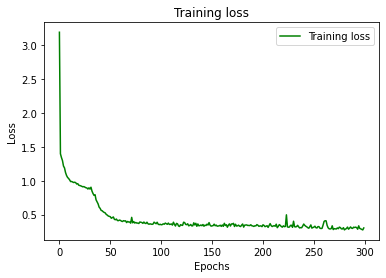

In [ ]:
plt.plot(history.epoch, history.history["loss"], 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis = -1)

In [ ]:
y_pred_enc = pd.get_dummies(y_pred)
y_test_enc = pd.get_dummies(y_test)

In [ ]:
print((y_test_enc.shape, y_pred_enc.shape))

((3000, 6), (3000, 5))


In [ ]:
y_pred_enc.value_counts()

0  1  2  3  4
0  1  0  0  0    2112
   0  0  0  1     424
1  0  0  0  0     316
0  0  1  0  0     101
      0  1  0      47
dtype: int64

In [ ]:
y_test_enc.value_counts()

HDF  No Failure  OSF  PWF  RNF  TWF
0    1           0    0    0    0      2903
1    0           0    0    0    0        34
0    0           1    0    0    0        22
                 0    1    0    0        21
                      0    0    1        16
                           1    0         4
dtype: int64

Our model did not predict any true values for the TWF column. We have to add one of all false values to make our classification report possible

In [ ]:
y_pred_enc['TWF'] = 0

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
print(accuracy_score(y_test_enc, y_pred_enc))

0.722


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
labels = np.unique(y_test)
print(classification_report(y_test_enc, y_pred_enc, target_names = labels))

              precision    recall  f1-score   support

         HDF       0.09      0.79      0.15        34
  No Failure       0.99      0.72      0.84      2903
         OSF       0.21      0.95      0.34        22
         PWF       0.40      0.90      0.56        21
         RNF       0.00      0.25      0.00         4
         TWF       0.00      0.00      0.00        16

   micro avg       0.72      0.72      0.72      3000
   macro avg       0.28      0.60      0.32      3000
weighted avg       0.97      0.72      0.82      3000
 samples avg       0.72      0.72      0.72      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


without oversampleing

In [ ]:
y_train_2 = pd.get_dummies(y_train)

Only using 20 epochs on the original data since it converges very fast

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation,Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
model_2 = Sequential()
model_2.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(16, activation='relu'))
model_2.add(Dense(8, activation='relu'))
model_2.add(Dense(6, activation='softmax'))
model_2.summary() 

# compile the model
model_2.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])


es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max',
                                   patience=10,
                                   restore_best_weights=True)


history2 = model_2.fit(X_train,
                    y_train_2,
                    epochs=50, 
                    validation_split=0.2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                576       
                                                                 
 dense_21 (Dense)            (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_22 (Dense)            (None, 16)                528       
                                                                 
 dense_23 (Dense)            (None, 8)                 136       
                                                                 
 dense_24 (Dense)            (None, 6)                 54        
                                                                 
Total params: 3,374
Trainable params: 3,374
Non-traina

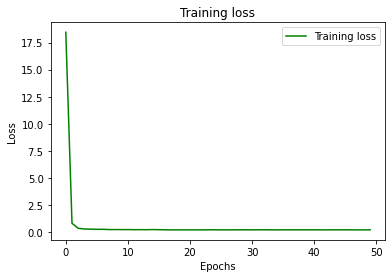

In [ ]:
plt.plot(history2.epoch, history2.history["loss"], 'g', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
y_pred2 = model_2.predict(X_test)
y_pred2 = np.argmax(y_pred2, axis = -1)
y_pred.shape


(3000,)

In [ ]:
y_pred_enc2 = pd.get_dummies(y_pred2)
y_test_enc2 = pd.get_dummies(y_test)
print((y_test_enc2.shape, y_pred_enc2.shape))

((3000, 6), (3000, 1))


In [ ]:
y_pred_enc2['RNF'] = 0
y_pred_enc2['TWF'] = 0
y_pred_enc2['PWF'] = 0

In [ ]:
y_pred_enc2

,1
0,1
1,1
2,1
3,1
4,1
...,...
2995,1
2996,1
2997,1
2998,1


In [ ]:
labels = np.unique(y_test)
print(classification_report(y_test_enc2, y_pred_enc2))

              precision    recall  f1-score   support

           0       0.01      0.82      0.02        34
           1       0.65      0.01      0.03      2903
           2       0.02      0.05      0.03        22
           3       0.00      0.00      0.00        21
           4       0.00      0.00      0.00         4
           5       0.00      0.00      0.00        16

   micro avg       0.02      0.02      0.02      3000
   macro avg       0.11      0.15      0.01      3000
weighted avg       0.62      0.02      0.03      3000
 samples avg       0.02      0.02      0.02      3000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print('ANN Original Data Accuracy' , accuracy_score(y_test_enc2, y_pred_enc2))
print('ANN Over sampled Data Accuracy' , accuracy_score(y_test_enc, y_pred_enc))

ANN Original Data Accuracy 0.023
ANN Over sampled Data Accuracy 0.722


Oversampled accuracy is about the same.